# The Annotated Transformer

**Focus**: understanding from "A First Example" section onwards.

**References**: 
- The Annotated Transformer, 2018 (https://nlp.seas.harvard.edu/2018/04/03/attention.html)

**Purpose**: 
- We want to improve translation quality of DL models as well as performance on NLP tasks.
- The goal of reducing sequential computation leads us to CNNs which compute hidden representaitons in parallel for all input and output positions. However, the number of operations required to relate signals from two arbitrary input or output positions grows in the distance between positions, linearly for ConvS2S and logrithmically for ByteNet.
- This makes it difficult to learn dependencies between distant positions.

**Approach**: 
- The Transformer, which leverages the attention mechanism, which reduces the number of operations required to relate signals from two arbitrary input or output positions to a constant number of operations.

**Result**: 
- A transformer model that is trained with parallelized computation across positions, enabling highly efficient training and SOTA results.
- On WMT 2014 English-to-Geman translation task, the big transformer model outperforms the best previously reported models by more than 2.0 BLEU.

**Definitions**: 

**Notes**:
- Multi-GPU training
- replicate = split modules onto different gpus (model architecture + criterion / loss function, generator)
- scatter = split batches onto different gpus
- parallel_apply = apply module to batches on different gpus
- gather = pull scattered data back onto one gpu (for loss computation and opt step)
- nn.DataParallel - calls these all before evaluating

Note: in multi-GPU training, it's really data parallelism where we scatter the batches.
- The multi-GPU training that they did here was use nn.DataParallel which handles full-model data parallelism, and then MultiGPULossCompute is another layer of parallelism for hte loss computation so that loss computation can be split across devices.

**FAQs**:
- Q: What does self.criterion = nn.KLDivLoss(size_average=False) do? What's the equation?

**Action items**:
- Finished reading through, kind of skimmed the end for "A Real World Example" instead of reproing for time. Can move on towards "The First Law of Complexodynamics": https://scottaaronson.blog/?p=762

In [65]:
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext seaborn 
!pip install numpy matplotlib spacy torchtext seaborn 
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cpu



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [66]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [67]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many other models
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        """Take in and process masked src and target sequences."""
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [68]:
class Generator(nn.Module):
    """Define standard linear + softmax generation step."""
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab) # logits (unnormalized logits for each token)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1) # log-probs

# Encoder and Decoder Stacks

## Encoder
The encoder is composed of a stack of N = 6 identical layers.

In [69]:
def clones(module, N):
    """Produce N identical layers."""
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
    """Core encoder is a stack of N layers"""
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        """Pass the input (and mask) through each layer in turn."""
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [71]:
class LayerNorm(nn.Module):
    """Construct a layernorm module."""
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2 # elementwise affine transformation

In [72]:
# assume d_model=512

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm. Pre-Layernorm
    Note for code simplicity the norm is first as opposed to last. Also note: this is the classic method of a Pre-LayerNorm now which is empirically better than a Post-LayerNorm where
    def forward(self, x, sublayer):
        return self.norm(x + self.dropout(sublayer(x)))
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [73]:
class EncoderLayer(nn.Module):
    "encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # MHA
        return self.sublayer[1](x, self.feed_forward) # FF

## Decoder

The decoder is also composed of a stack of N = 6 identical layers.

In [74]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size) # d_model

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [75]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [76]:
def subsequent_mask(size):
    "Mask out subsequent posiitons."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') # sets everything below the 1 upper triangle to 0
    return torch.from_numpy(subsequent_mask) == 0

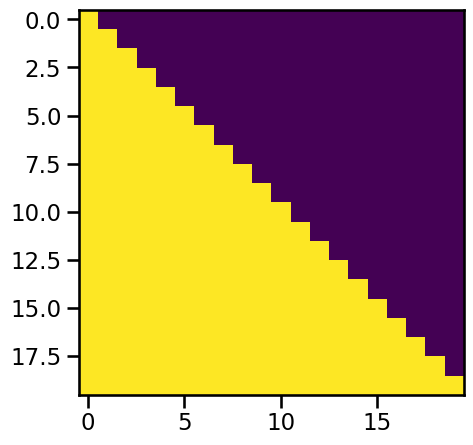

In [77]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

## Attention

Scaled Dot-Product Attention
Input: queries and keys of dimension d_k, values of dimension d_v

In [78]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) # affinities / compatibility function
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1) # weights
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. 

Employ h = 8 parallel attention layers/heads

d_k = d_v = d_model / h = 64

512 / 8 = 64

In [79]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4) # Wq, Wk, Wv, Wo
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)

        return self.linears[-1](x)

## Position-wise Feed-Forward Networks
Q: Do you need a mask for this FFN? Or I guess not? 
- A: No, the FFN just transforms one token embedding into another token embedding. That's it.

Another way of describing this is as two convolutions with kernel size 1, projecting it from some input embedding dimension 1 to output embedding dimension 1, and then another one to project to output embeding dimension 2

Input and output dimension = d_model = 512, inner-layer has d_ff = 2048 (512 * 4)

In [80]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings and Softmax
norm = length / magnitude of a vector

Euclidean norm (L2 norm) = ||x||_2 = \sqrt(x_1^2 + x_2^2 + ... + x_n^2)

Remember, Mean(X) = E[X] and Var(X) = E[(X - E[X])^2]

When mean = 0, then Var(X) = E[X^2]

Expected Squared Norm = 

E[||e_tok||^2] = E[x_1^2] + E[x_2^2] + ... + E[x_d_model^2]

E[||e_tok||^2] = Var(x_1^2) + Var(x_2^2) + ... + Var(x_d_model^2)

E[||e_tok||^2] = 1

E[||e_tok||] = 1

Positional encodings also all have magnitude 1. 

In [81]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model) # lookup table where rows = vocabulary items size vocab and cols = embedding dimensions d_model. Note: nn.Embedding by default initializes each dimenion to have variance = 1/d_model s.t. expected vector norm = 1.
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model) # scaling to not have positional encodings dominate # the key reason why we scale is because many sublayers like attention product outputs with variance = 1 per dimension. Therefore, to get the embedding's per-dimension variance to be variance = 1 instead of 1/d_model, we need to multiply by \sqrt(self.d_model), assuming nn.Embedding initialized each dimension with variance 1/d_model so that the embedding vector norm = 1 # Therefore, we want all our vectors to have variance d_model.

## Positional Encoding

Positional encodings can be learned or fixed, we'll use fixed sine and consine functions of different frequencies: 

PE_{(pos,2i)} = sin(pos/10000**{2i/d_model})

PE_{(pos,2i+1)} = cos(pos/10000**{2i/d_model})



In [82]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model) # (N, D)
        position = torch.arange(0, max_len).unsqueeze(1) # (N, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)) # (D//2)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # (1, N, D)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],
                         requires_grad=False)
        return self.dropout(x)

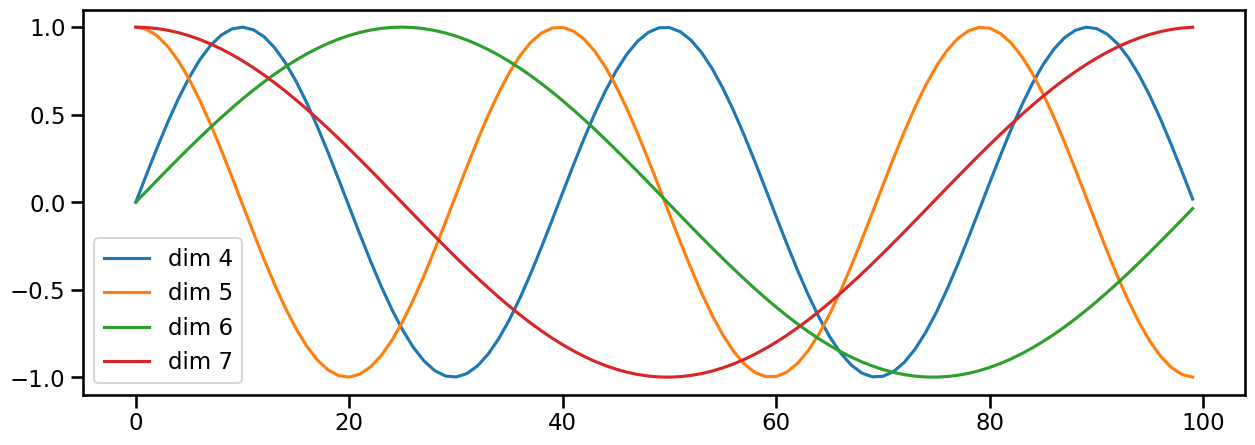

In [83]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20))) # (batch_size=1, seq_len=100, d_model=20)
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy()) # just looking at dimensions 4-7 positional encodings
plt.legend(["dim %d"%p for p in [4, 5, 6, 7]])

## Full Model
function that takes in hyperparameters and produces a full model

In [84]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparamteters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )

    # This was apparently important from their code?
    # Initialize parameters with GLorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [85]:
# Small example model.
tmp_model = make_model(10, 10, 2)

C:\Users\kevihuang\AppData\Local\Temp\ipykernel_4420\4151607716.py:19: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(p)


# Training

## Batches and Masking

In [86]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0): # src = (N, M) = encoder input sequence
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2) # unsqueeze a batch dim (B, N, M)
        if trg is not None:
            self.trg = trg[:, :-1] # decoder input sequence
            self.trg_y = trg[:, 1:] # decoder output sequence for NTP
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [87]:
# Training Loop

def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss %f Tokens per Sec: %f" % (i, loss / batch.ntokens, tokens / elapsed))
        start = time.time()
        tokens = 0
    return total_loss / total_tokens

In [88]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.trg) + 2) # probably for adding <BOS> (begin of sentence) and <EOS> (end of sentence)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

# Optimizer

In [89]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate # Note: looks like the learning rate warmup and then decay is very important.
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5)*
             min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

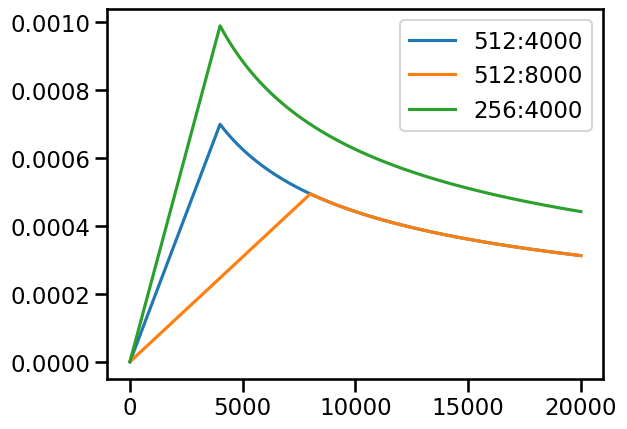

In [90]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),  # increasing the warmup makes the warmup take longer
        NoamOpt(256, 1, 4000, None)] # halving the model size increases the warmup / peak learning rate
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

# Label Smoothing

In [91]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2)) # remove the true class and padding token. assign self.smoothing / (self.size - 2) to the rest of the tokens
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

c:\Users\kevihuang\projects\sketchbook\venv\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


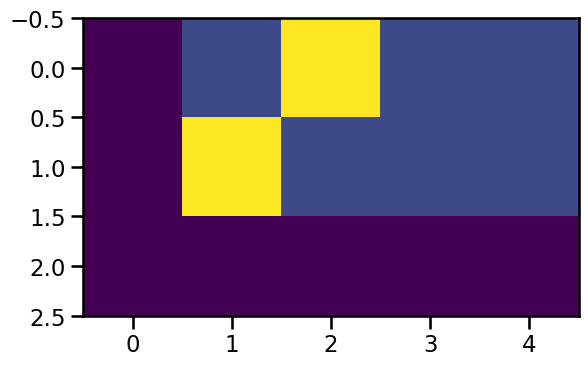

In [92]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                            [0, 0.2, 0.7, 0.1, 0],
                            [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()),
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)

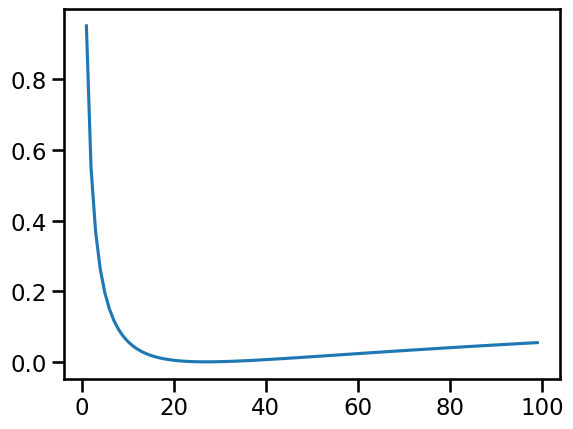

In [93]:
crit = LabelSmoothing(5, 0, 0.1) # The smoothed target for the correct class is t = [0, 0.9, 0.025, 0.025, 0.025, 0.025]

def loss(x):
    d = x + 3 * 1
    predict = torch.tensor([[0, x / d, 1 / d, 1 / d, 1 / d]], dtype=torch.float32) # padding for 0, x/(x + 3), 1/(x+3), ...
    predict = predict / predict.sum(-1, keepdim=True)
    log_probs = torch.log(predict.clamp(min=1e-9))
    #print(predict)
    return crit(log_probs, torch.tensor([1])).item()
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

# Key idea is that x axis = confidence of prediction, so as the model gets very confident (100%), the loss increases. If the model is NOT confident (0%), the loss is extremely high. The lowest loss is when the model is roughly at 30% confident?
# This toy example can't actually hit target, but the best we can do is get close which happens around x = 30

# A First Example
Simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols.

In [94]:
# Synthetic Data

def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10))) # (B, N) from (1, V)
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False) # copy operation
        yield Batch(src, tgt, 0)

In [97]:
# Loss Computation

class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion # loss function
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x) # generate logprobs
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), # assuming x.size(-1).shape = (V,), where x = (B, N, V) and y = (B, N) target chars
                              y.contiguous().view(-1)) / norm # / norm to keep gradients properly scaled. norm = # of tokens (N). So effectively computing loss per token, making sure gradients don't depend on batch size or sequence length, keeping training stable
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad() # zero out gradients for next grad accum step
        return loss.item() * norm # report total loss over the batch, not the averaged one to aggregate over multiple batches (you can get loss / epoch), and then average      

In [98]:
# Greedy Decoding

# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0) # Note: no smoothing, so one hot vector targets
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
                    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model,
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model,
                    SimpleLossCompute(model.generator, criterion, None)))

c:\Users\kevihuang\projects\sketchbook\venv\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\kevihuang\AppData\Local\Temp\ipykernel_4420\4151607716.py:19: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(p)


Epoch Step: 1 Loss 3.177770 Tokens per Sec: 769.270325
Epoch Step: 1 Loss 1.907695 Tokens per Sec: 1594.502686
tensor(1.8724)
Epoch Step: 1 Loss 2.027192 Tokens per Sec: 959.297363
Epoch Step: 1 Loss 1.629231 Tokens per Sec: 1581.295410
tensor(1.6179)
Epoch Step: 1 Loss 1.831133 Tokens per Sec: 1074.105957
Epoch Step: 1 Loss 1.317492 Tokens per Sec: 1450.260620
tensor(1.3772)
Epoch Step: 1 Loss 1.660831 Tokens per Sec: 892.137939
Epoch Step: 1 Loss 1.300968 Tokens per Sec: 1576.342896
tensor(1.2326)
Epoch Step: 1 Loss 1.348066 Tokens per Sec: 936.691650
Epoch Step: 1 Loss 1.027549 Tokens per Sec: 1570.077148
tensor(1.0217)
Epoch Step: 1 Loss 1.167088 Tokens per Sec: 946.850098
Epoch Step: 1 Loss 0.617894 Tokens per Sec: 1310.128662
tensor(0.6392)
Epoch Step: 1 Loss 1.024646 Tokens per Sec: 993.250977
Epoch Step: 1 Loss 0.476591 Tokens per Sec: 1545.989502
tensor(0.4991)
Epoch Step: 1 Loss 0.663022 Tokens per Sec: 999.569336
Epoch Step: 1 Loss 0.452154 Tokens per Sec: 1581.832153
tensor

In [99]:
# This code predicts a translation using greedy decoding for simplicity.

def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask) # important: this is the encoder layer that runs through self-attn and ff layers
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data) # initialize the decoder starting sequence with a <BOS> token
    for i in range(max_len-1):
        out = model.decode(memory, src_mask,
                           Variable(ys),
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1) # greedy decoding, take the token with the highest probability. Returns probability, index of the token id (tensor)
        next_word = next_word.item() # grab the token id itself from the tensor
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1) # (1, N)
        
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]))
src_mask = Variable(torch.ones(1, 1, 10)) # bs=1, query_length_dim=1, src_len=10
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])


In [100]:
# Moved to just reading the blog post instead of trying to repro for now given it takes an extremely long time to repro